<a href="https://colab.research.google.com/github/naingwinkyaw/IT123-Project_ID4288602M_/blob/main/03_IT123_Project_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IT123 Project - "Model Development AI-Driven Indoor Air Quality Monitoring System" using CO2 levels

Building a time series model for forecasting.
Since levels usually exhibit both a long-term upward trend and seasonal fluctuations, an LSTM (Long Short-Term Memory) network is a great choice because it can "remember" those long-term patterns.
Below is a complete implementation using TensorFlow/Keras.

1. Setup


In [1]:
# Setup and Loading Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
from google.colab import files



- Create Data directory and load the raw csv data into Data directory.

In [2]:
#Creating Data directory
!mkdir data

         Before Loading Data runs, copy "IoT_Indoor_Air_Quality_Dataset" to "Data" folder.

In [4]:
#Loading data
# Configuration
data_dir = './data'
file_name = 'IoT_Indoor_Air_Quality_Dataset.csv'
file_path = os.path.join(data_dir, file_name)

# 1. Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Upload the dataset if it's not already present
if not os.path.exists(file_path):
  uploaded = files.upload()
  # Assuming only one file is uploaded, get its name
  if uploaded:
    uploaded_file_name = list(uploaded.keys())[0]
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=uploaded_file_name, length=len(uploaded[uploaded_file_name])))

    # Move the uploaded file to the data directory and rename it to the expected file_name
    os.rename(uploaded_file_name, file_path)
    print(f"File '{uploaded_file_name}' moved to '{file_path}'")
    if uploaded_file_name != file_name:
      print(f"Warning: The uploaded file name '{uploaded_file_name}' was renamed to '{file_name}' to match the expected file name.")
  else:
    print("No file was uploaded. Please upload the dataset.")

# Load the dataset
df = pd.read_csv(file_path)

# Display basic info and the first few rows
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97458 entries, 0 to 97457
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              97458 non-null  object 
 1   Temperature (?C)       95509 non-null  float64
 2   Humidity (%)           95509 non-null  float64
 3   CO2 (ppm)              95509 non-null  float64
 4   PM2.5 (?g/m?)          95509 non-null  float64
 5   PM10 (?g/m?)           95509 non-null  float64
 6   TVOC (ppb)             95509 non-null  float64
 7   CO (ppm)               95509 non-null  float64
 8   Light Intensity (lux)  95509 non-null  float64
 9   Motion Detected        95509 non-null  float64
 10  Occupancy Count        95509 non-null  float64
 11  Ventilation Status     95509 non-null  object 
dtypes: float64(10), object(2)
memory usage: 8.9+ MB
None
          Timestamp  Temperature (?C)  Humidity (%)  CO2 (ppm)  PM2.5 (?g/m?)  \
0  18-02-2024 08:00     

- Convert Timestamps into datetime format.

Data ranges from 2024-02-18 08:00:00 to 2025-01-22 17:25:00
count    97458.000000
mean       700.342582
std        172.604190
min        400.000000
25%        551.230000
50%        700.540000
75%        849.205000
max        999.990000
Name: CO2 (ppm), dtype: float64


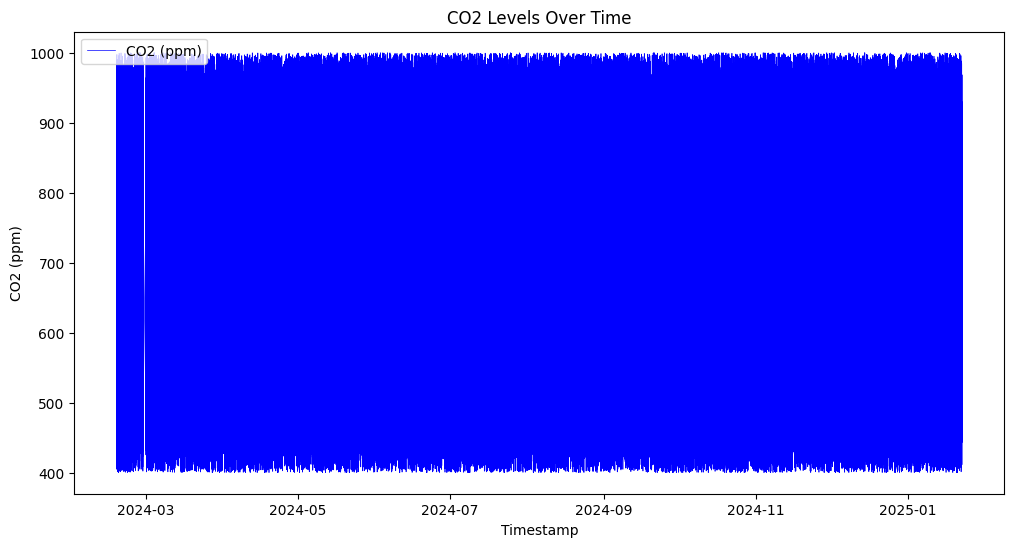

In [5]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')

# Sort by timestamp
df = df.sort_values('Timestamp').reset_index(drop=True)

# Interpolate missing values for CO2
df['CO2 (ppm)'] = df['CO2 (ppm)'].interpolate(method='linear')

# Drop remaining NaNs in CO2 if any
df = df.dropna(subset=['CO2 (ppm)'])

# Check time range
start_time = df['Timestamp'].min()
end_time = df['Timestamp'].max()
print(f"Data ranges from {start_time} to {end_time}")

# Plot CO2 over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['CO2 (ppm)'], label='CO2 (ppm)', color='blue', linewidth=0.5)
plt.title('CO2 Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.savefig('co2_time_series.png')

# Summary statistics for CO2
print(df['CO2 (ppm)'].describe())

1. Load and Pre-process Data

In [12]:
# 1. Load and Preprocess Data
df = pd.read_csv('./data/IoT_Indoor_Air_Quality_Dataset.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df = df.sort_values('Timestamp').dropna(subset=['CO2 (ppm)'])

# Using a subset for faster training (last 10000 rows is plenty for a demo)
data = df[['CO2 (ppm)']].values[-10000:]

# Scale data
# Feature Scaling (LSTMs are sensitive to the scale of input data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

2. Data Normalisation & Create Sequence Generation (Sliding Window)

In [7]:
# Use the preprocessed 'CO2 (ppm)' column from the existing dataframe 'df'
data = df['CO2 (ppm)'].values.reshape(-1, 1)

# 1. Normalize the data to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# 2. Create Sequences (Sliding Window)
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

# Window of 60 steps (5 hours of history)
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split: Last 288 steps (24 hours) for testing
test_size = 288
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]



3. Build LSTM Model
- We define a simple RNN structure. The input shape must be (samples, time_steps, features).




In [70]:
# 3. Build LSTM Model
model = Sequential([
     LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
     Dropout(0.2),
     LSTM(32),
     Dropout(0.2),
     Dense(1)   # Predicting a single value
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4. Train the model

In [71]:
# 4. Train Model
# Using 5x epochs for speed in environment
print("Training model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)



Training model...
Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1226 - val_loss: 0.0853
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0876 - val_loss: 0.0848
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0879 - val_loss: 0.0844
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0879 - val_loss: 0.0842
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0870 - val_loss: 0.0842


5 Forecast and Evaluate (Part 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
Evaluation Metrics:
MAE: 141.54
RMSE: 165.58
R2 Score: -0.00


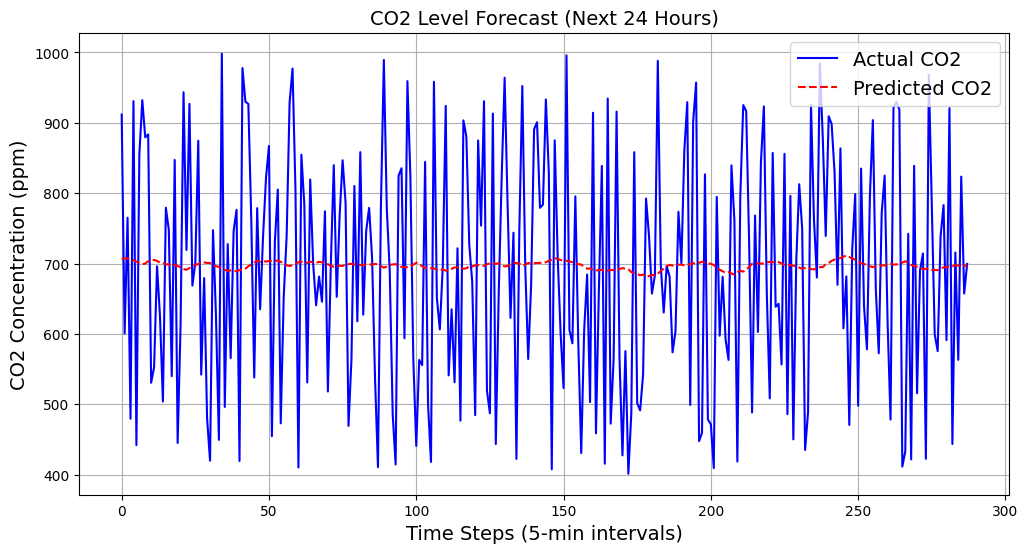

In [72]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)


Train, Forecast, Evaluate for 10 Epochs

In [73]:
# 4. Train Model
# Using 10x epochs for speed in environment
print("Training model...")
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)



Training model...
Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0862 - val_loss: 0.0845
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0867 - val_loss: 0.0844
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0850 - val_loss: 0.0847
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0866 - val_loss: 0.0842
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0853 - val_loss: 0.0841
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0845 - val_loss: 0.0843
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0866 - val_loss: 0.0848
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0859 - val_loss: 0.0848
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0859 - val_loss: 0.0841
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0834 - val_loss: 0.0841


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Evaluation Metrics:
MAE: 141.42
RMSE: 165.41
R2 Score: -0.00


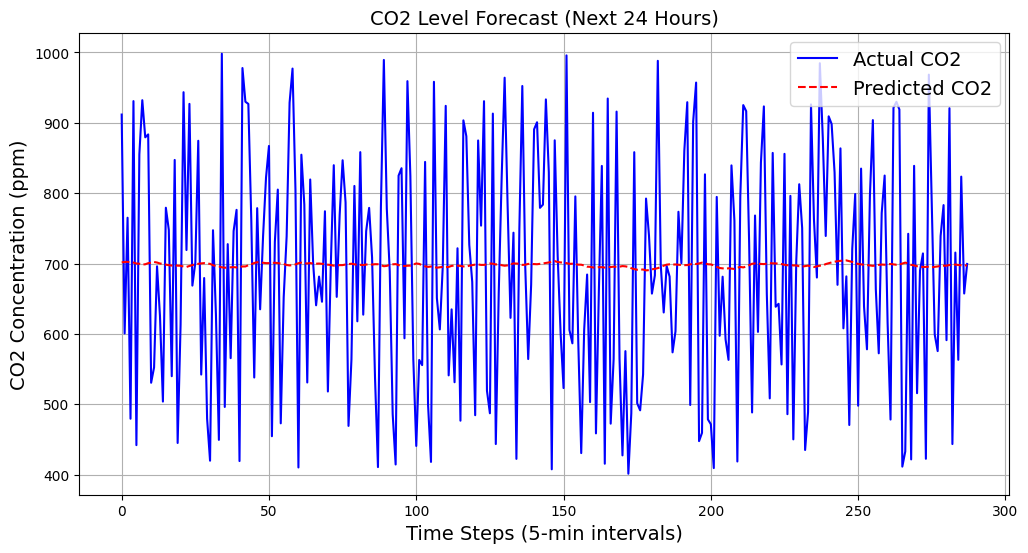

In [74]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast1_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)


** Alternative Building with WINDOW SIZE (Sequence Generation - Windowing)

In [75]:
# 2. Create sequences (Windowing)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 12  # Use 12 months to predict the 13th month
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split into train and test sets (80/20)
#split = int(len(X) * 0.8)
#X_train, X_test = X[:split], X[split:]
#y_train, y_test = y[:split], y[split:]


# Split: Last 288 steps (24 hours) for testing
test_size = 288
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]



# 3. Build the Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1) # Predicting a single value
])

model.compile(optimizer='adam', loss='mse')

# 4. Train
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Training model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


607/607 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1049 - val_loss: 0.0767
Epoch 2/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0849 - val_loss: 0.0765
Epoch 3/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0855 - val_loss: 0.0763
Epoch 4/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0842 - val_loss: 0.0768
Epoch 5/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0854 - val_loss: 0.0773
Epoch 6/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0839 - val_loss: 0.0761
Epoch 7/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0844 - val_loss: 0.0768
Epoch 8/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0831 - val_loss: 0.0766
Epoch 9/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0828 - val_loss: 0.0761
Epoch 10/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0831 - val_loss: 0.0760


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Evaluation Metrics:
MAE: 141.63
RMSE: 165.37
R2 Score: -0.00


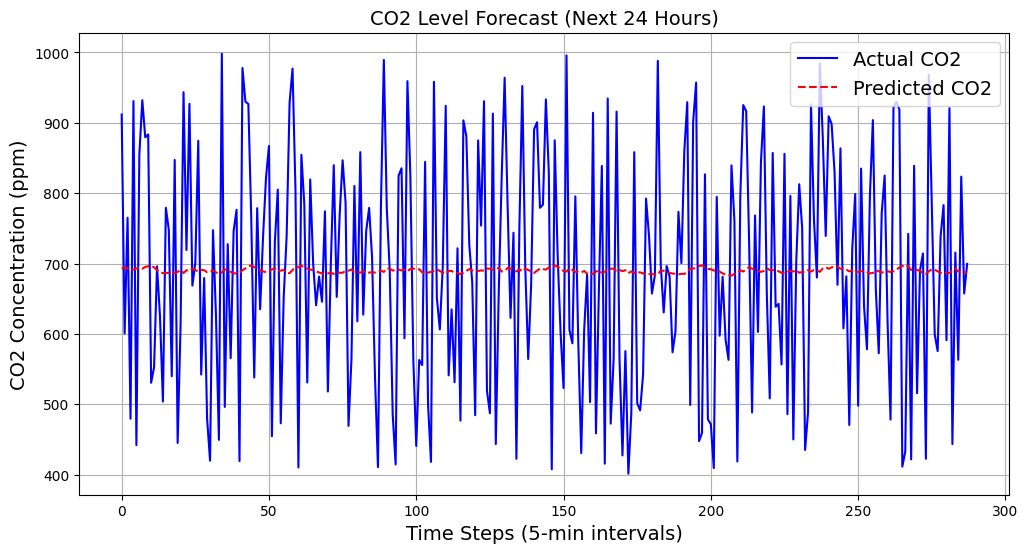

In [76]:
# 5. Forecast and Evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"Evaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual CO2', color='blue')
plt.plot(predictions, label='Predicted CO2', color='red', linestyle='dashed')
plt.title('CO2 Level Forecast (Next 24 Hours)')
plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.savefig('co2_forecast2_plot.png')

# Save predictions for user
forecast_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})
forecast_df.to_csv('co2_forecast_results.csv', index=True)


## Setup for PyTorch

Install required dependencies and to ensure Pytorch is >= 2.6.0.

In [16]:
%pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.1 MB/s eta 0:00:00


In [17]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

In [18]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():  # for MacOS
    device = "mps"
else:
    device = "cpu"

In [19]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [20]:
len(df)

95509

In [21]:
df.head()

,Timestamp,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count,Ventilation Status
0,2024-02-18 08:00:00,21.75,63.11,989.74,31.17,89.66,226.83,2.84,646.86,0.0,49.0,Open
1,2024-02-18 08:05:00,27.51,68.03,924.59,27.32,44.82,116.76,3.12,845.45,1.0,11.0,Open
2,2024-02-18 08:10:00,25.32,53.51,604.05,73.84,71.08,56.59,3.59,560.03,1.0,29.0,Closed
3,2024-02-18 08:15:00,23.99,58.52,692.20,62.94,10.90,228.06,2.66,499.84,1.0,28.0,Closed
4,2024-02-18 08:20:00,19.56,69.34,533.12,26.56,88.06,267.26,1.76,411.36,1.0,16.0,Closed


### Longer-term seasonality

For time series data, it is also useful to examine if there is any longer term seasonality such as yearly seasonality. We can use differencing to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain the same over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

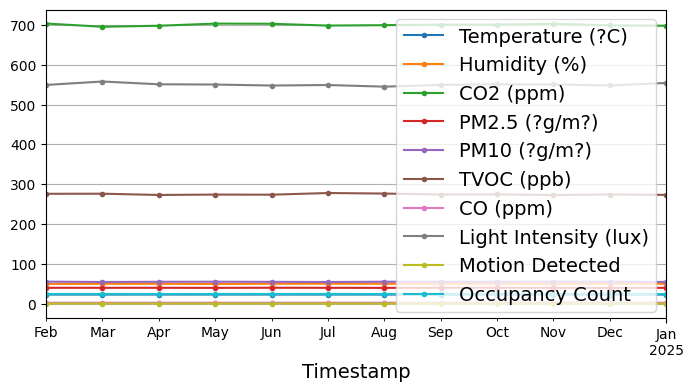

In [22]:
period = slice("2024-02", "2025-01") # Adjusted to monthly granularity
# Set the 'Timestamp' column as the index before resampling
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True) # Ensure 'Timestamp' is datetime
df_indexed = df.set_index('Timestamp')
df_monthly = df_indexed.select_dtypes(include="number").resample('ME').mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

Now we remove the yearly seasonality and take a look at the data. The trend is gone and the data looks more stationary.

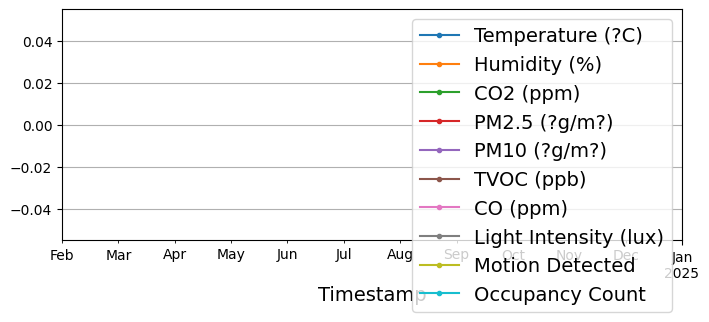

In [23]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

Preparing the Data for Machine Learning Model

For this modelling exercise, we want to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

For training data, will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it. To do that, we need to create a custom dataset that will chop a given time series into all possible windows of a given length, each with its corresponding target:

In [24]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return len(self.series) - self.window_length

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end]
        return window, target

Let's test if our TimeSeriesDataset is functioning correctly.

In [25]:
my_series = torch.tensor([[0], [1], [2], [3], [4], [5]])
my_dataset = TimeSeriesDataset(my_series, window_length=3)
for series, target in my_dataset:
    print("Series:", series, " Target:", target)

Series: tensor([[0],
        [1],
        [2]])  Target: tensor([3])
Series: tensor([[1],
        [2],
        [3]])  Target: tensor([4])
Series: tensor([[2],
        [3],
        [4]])  Target: tensor([5])


Now we can create a DataLoader for this tiny dataset, shuffling the windows and grouping them into batches of two:

In [26]:
from torch.utils.data import DataLoader
torch.manual_seed(0)
my_loader = DataLoader(my_dataset, batch_size=2, shuffle=True)
for i, (X, y) in enumerate(my_loader):
    print(f"batch {i}\nX:", X, " y:", y)

batch 0
X: tensor([[[0],
         [1],
         [2]],

        [[2],
         [3],
         [4]]])  y: tensor([[3],
        [5]])
batch 1
X: tensor([[[1],
         [2],
         [3]]])  y: tensor([[4]])


Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. When dealing with time series, you generally want to split across time.

We will convert the data to 32-bit float tensors, and scale them down by a factor of one million to ensure the values end up near the 0–1 range; this plays nicely with the default weight initialization and learning rate.



In [27]:
# Ensure 'Timestamp' is datetime and set it as the index for time-based slicing
df_indexed = df.set_index('Timestamp')

# Adjusting date ranges to match the actual dataset time frame (2024-02 to 2025-01)
# Example ranges, adjust as needed for your training, validation, and test split
CO2_train = torch.FloatTensor(df_indexed["CO2 (ppm)"]["2024-02":"2024-09"].values / 1e6)
CO2_valid = torch.FloatTensor(df_indexed["CO2 (ppm)"]["2024-10":"2024-11"].values / 1e6)
CO2_test = torch.FloatTensor(df_indexed["CO2 (ppm)"]["2024-12":"2025-01"].values / 1e6)


The tensor produced is a 1D tensor, but for time series data, we need a 2D tensor of shape (time, feature). Let's add in additional dimension by using Pytorch unsqueeze() function.

In [28]:
CO2_train.shape

torch.Size([63398])

In [30]:
CO2_train = CO2_train.unsqueeze(1)
CO2_valid = CO2_valid.unsqueeze(1)
CO2_test = CO2_test.unsqueeze(1)
print(CO2_train.shape)

torch.Size([63398, 1])


Next, let’s use our TimeSeriesDataset class to create datasets for training, validation, and testing, and also create the corresponding data loaders. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set shuffle to True - this will shuffle the windows, but not their contents:



In [31]:
window_length = 56
train_set = TimeSeriesDataset(CO2_train, window_length)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = TimeSeriesDataset(CO2_valid, window_length)
valid_loader = DataLoader(valid_set, batch_size=32)
test_set = TimeSeriesDataset(CO2_test, window_length)
test_loader = DataLoader(test_set, batch_size=32)

In [32]:
for X, y in valid_loader:
    # print("X:", X)
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 56, 1])
torch.Size([32, 1])


Now we’re ready to build and train our forecasting model using RNN and LSTM.

Training Sequence Model

Let's build some convenience methods first to evaluate and to train. We choose Huber Loss as it is more robust to outliers and have smoother gradients for optimization.

In [33]:
import torch.nn as nn
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50,
                     patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)
    # metric = torchmetrics.MeanAbsoluteError().to(device)
    metric = torchmetrics.MeanAbsolutePercentageError().to(device)
    history = train(model, optimizer, loss_fn, metric,
                    train_loader, valid_loader, n_epochs=n_epochs,
                    patience=patience, factor=factor)
    # return min(history["valid_metrics"]) * 1e6
    return min(history["valid_metrics"]) * 100 # percentage

## Using a Simple RNN

In [34]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [35]:
torch.manual_seed(42)
model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)
model = model.to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0000, train metric: 2.1314, valid metric: 0.2468
Epoch 2/50, train loss: 0.0000, train metric: 0.2406, valid metric: 0.2543
Epoch 3/50, train loss: 0.0000, train metric: 0.2413, valid metric: 0.2399
Epoch 4/50, train loss: 0.0000, train metric: 0.2407, valid metric: 0.2267
Epoch 5/50, train loss: 0.0000, train metric: 0.2415, valid metric: 0.2446
Epoch 6/50, train loss: 0.0000, train metric: 0.2405, valid metric: 0.2505
Epoch 7/50, train loss: 0.0000, train metric: 0.2412, valid metric: 0.2461
Epoch 8/50, train loss: 0.0000, train metric: 0.2426, valid metric: 0.2540
Epoch 9/50, train loss: 0.0000, train metric: 0.2411, valid metric: 0.2385
Epoch 10/50, train loss: 0.0000, train metric: 0.2411, valid metric: 0.2301
Epoch 11/50, train loss: 0.0000, train metric: 0.2402, valid metric: 0.2532
Epoch 12/50, train loss: 0.0000, train metric: 0.2419, valid metric: 0.2323
Epoch 13/50, train loss: 0.0000, train metric: 0.2410, valid metric: 0.2414
Epoch 14/50, train lo

22.587600350379944

Deep RNNs

We can also stack multiple layers of RNN cells, just like CNN. In the code below, we add in additional num_layers argument so that we can instantiate multi-layer RNN.

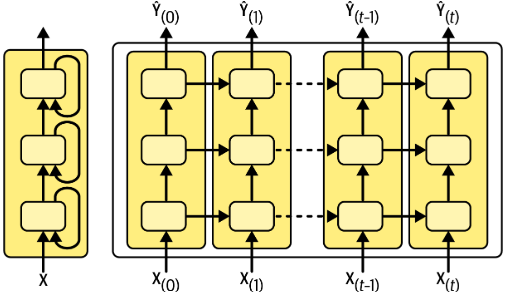



In [36]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        # print(outputs.shape)
        # print(outputs[:, -1].shape)
        return self.output(outputs[:, -1])

In [37]:
torch.manual_seed(42)
model = DeepRnnModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.07, n_epochs=50)

Epoch 1/50, train loss: 0.0002, train metric: 4.5161, valid metric: 0.2341
Epoch 2/50, train loss: 0.0000, train metric: 0.2396, valid metric: 0.2488
Epoch 3/50, train loss: 0.0000, train metric: 0.2399, valid metric: 0.2423
Epoch 4/50, train loss: 0.0000, train metric: 0.2390, valid metric: 0.2253
Epoch 5/50, train loss: 0.0000, train metric: 0.2393, valid metric: 0.2404
Epoch 6/50, train loss: 0.0000, train metric: 0.2390, valid metric: 0.2330
Epoch 7/50, train loss: 0.0000, train metric: 0.2392, valid metric: 0.2418
Epoch 8/50, train loss: 0.0000, train metric: 0.2396, valid metric: 0.2407
Epoch 9/50, train loss: 0.0000, train metric: 0.2387, valid metric: 0.2282
Epoch 10/50, train loss: 0.0000, train metric: 0.2393, valid metric: 0.2669
Epoch 11/50, train loss: 0.0000, train metric: 0.2395, valid metric: 0.2338
Epoch 12/50, train loss: 0.0000, train metric: 0.2395, valid metric: 0.2310
Epoch 13/50, train loss: 0.0000, train metric: 0.2392, valid metric: 0.2260
Epoch 14/50, train lo

22.527559101581573

We can see some slight improvements in the forecast errors, measured by MAPE.

Using LSTM

In [38]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [41]:
torch.manual_seed(42)
model = LstmModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=1).to(device)
fit_and_evaluate(model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0000, train metric: 1.0364, valid metric: 0.2349
Epoch 2/50, train loss: 0.0000, train metric: 0.2387, valid metric: 0.2375
Epoch 3/50, train loss: 0.0000, train metric: 0.2388, valid metric: 0.2606
Epoch 4/50, train loss: 0.0000, train metric: 0.2384, valid metric: 0.2422
Epoch 5/50, train loss: 0.0000, train metric: 0.2388, valid metric: 0.2361
Epoch 6/50, train loss: 0.0000, train metric: 0.2386, valid metric: 0.2545
Epoch 7/50, train loss: 0.0000, train metric: 0.2383, valid metric: 0.2421
Epoch 8/50, train loss: 0.0000, train metric: 0.2383, valid metric: 0.2318
Epoch 9/50, train loss: 0.0000, train metric: 0.2387, valid metric: 0.2360
Epoch 10/50, train loss: 0.0000, train metric: 0.2387, valid metric: 0.2373
Epoch 11/50, train loss: 0.0000, train metric: 0.2388, valid metric: 0.2310
Epoch 12/50, train loss: 0.0000, train metric: 0.2386, valid metric: 0.2413
Epoch 13/50, train loss: 0.0000, train metric: 0.2386, valid metric: 0.2301
Epoch 14/50, train lo

22.547326982021332

Observation about the performance of LSTM:

Multivariate Prediction

So far, we have been looking at time series with only a single feature (i.e. the number of riders), or a univariate time series. Our models such as RNN/LTSTM can easily handle multivariate sequence data, without any need to change the codes.

Let's create a new dataset with multiple features now. We know from previous EDA, that public holiday or weekend affects the ridership. If we know that tomorrow is a public holiday, we can predict a lower ridership.

So let's create a new feature called next_day_type by shifting the day type series one day into the future. We can do so easily with shift(-1) with the panda series. We also one-hot-encode the next_day_type using get_dummies() function.

In [43]:
# Select relevant columns for multivariate prediction from the Indoor Air Quality dataset
# The original code referred to 'rail' and 'day_type' which are not in this dataset.
# Assuming CO2 (ppm) is the primary target, and others are features.
df_mulvar = df[['CO2 (ppm)', 'Temperature (?C)', 'Humidity (%)', 'PM2.5 (?g/m?)']]

# Display the head of the new multivariate DataFrame
print(df_mulvar.head())

   CO2 (ppm)  Temperature (?C)  Humidity (%)  PM2.5 (?g/m?)
0     989.74             21.75         63.11          31.17
1     924.59             27.51         68.03          27.32
2     604.05             25.32         53.51          73.84
3     692.20             23.99         58.52          62.94
4     533.12             19.56         69.34          26.56


In [44]:
df_mulvar.head()

,CO2 (ppm),Temperature (?C),Humidity (%),PM2.5 (?g/m?)
0,989.74,21.75,63.11,31.17
1,924.59,27.51,68.03,27.32
2,604.05,25.32,53.51,73.84
3,692.20,23.99,58.52,62.94
4,533.12,19.56,69.34,26.56


We convert the data frame into torch tensors.



In [46]:
# Ensure 'Timestamp' is datetime and set it as the index for time-based slicing
df_mulvar_indexed = df[['CO2 (ppm)', 'Temperature (?C)', 'Humidity (%)', 'PM2.5 (?g/m?)', 'Timestamp']].set_index('Timestamp')

# Adjusting date ranges to match the actual dataset time frame (2024-02 to 2025-01)
# Example ranges, adjust as needed for your training, validation, and test split
mulvar_train = torch.FloatTensor(df_mulvar_indexed["2024-02":"2024-09"].values / 1e6)
mulvar_valid = torch.FloatTensor(df_mulvar_indexed["2024-10":"2024-11"].values / 1e6)
mulvar_test = torch.FloatTensor(df_mulvar_indexed["2024-12":"2025-01"].values / 1e6)

If we used the TimeSeriesDataset as before, the targets would include the next day’s rail ridership, as well as the one-hot encoding of the following day type. We must tweak the TimeSeriesDataset to keep only the first value in the target, which is the rail ridership. One way to do this is to create a new MulvarTimeSeriesDataset class that extends the TimeSeriesDataset class and tweaks the getitem() method to filter the target:

In [47]:
class MulvarTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:1]

In [48]:
window_length = 56
mulvar_train_set = MulvarTimeSeriesDataset(mulvar_train, window_length)
mulvar_train_loader = DataLoader(mulvar_train_set, batch_size=32, shuffle=True)
mulvar_valid_set = MulvarTimeSeriesDataset(mulvar_valid, window_length)
mulvar_valid_loader = DataLoader(mulvar_valid_set, batch_size=32)
mulvar_test_set = MulvarTimeSeriesDataset(mulvar_test, window_length)
mulvar_test_loader = DataLoader(mulvar_test_set, batch_size=32)

Let's make sure the the X and y returned are of expected shape, before using them for training our model.

In [49]:
for X, y in mulvar_train_set:
    print(X.shape)
    print(y.shape)
    break

torch.Size([56, 4])
torch.Size([1])


In [50]:
print(y)

tensor([0.0005])


Let's try with our Deep RNN model, by changing the input_size to match the number of features, in this case 4.

In [51]:
# torch.manual_seed(42)
model = DeepRnnModel(
    input_size=4, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(model, mulvar_train_loader, mulvar_valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 2/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 3/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 4/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 5/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 6/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 7/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 8/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 9/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 10/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 11/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 12/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 13/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 14/50, train loss: nan, train metric: nan, valid metric: nan
Epoch 15/50, train loss: nan, train metric: nan, valid metric: nan
Epoc

nan

Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead).

Test result if we want to predict the next 14 values with a single model.

Now let's create an RNN that predicts the rail ridership for the next 14 days all at once, using the time series we built earlier. For this, we first need to prepare datasets appropriately.

We created a new dataset that inherits from the TimeSeriesDataset class and tweaks its __len__() and __getitem__() methods. The target is now a tensor containing the next 14 rail ridership values, rather than just the next value.

In [52]:
class ForecastAheadDataset(TimeSeriesDataset):
    def __len__(self):
        return len(self.series) - self.window_length - 14 + 1

    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end : end + 14, 0]  # 0 = rail ridership
        return window, target

In [53]:
window_length = 56
ahead_train_set = ForecastAheadDataset(mulvar_train, window_length)
ahead_train_loader = DataLoader(ahead_train_set, batch_size=32, shuffle=True)
ahead_valid_set = ForecastAheadDataset(mulvar_valid, window_length)
ahead_valid_loader = DataLoader(ahead_valid_set, batch_size=32)
ahead_test_set = ForecastAheadDataset(mulvar_test, window_length)
ahead_test_loader = DataLoader(ahead_test_set, batch_size=32)

In [54]:
for x, y in ahead_train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 56, 4])
torch.Size([32, 14])


In [55]:
print(x[0])

tensor([[9.5723e-04, 1.8350e-05, 6.1900e-05, 5.6900e-06],
        [6.5997e-04, 2.7750e-05, 4.9650e-05, 5.0660e-05],
        [8.7774e-04,        nan, 3.5140e-05, 1.7650e-05],
        [6.4173e-04, 2.2320e-05, 6.8160e-05, 5.0850e-05],
        [8.1365e-04, 2.4280e-05,        nan, 6.2450e-05],
        [4.5311e-04, 1.9230e-05, 3.9810e-05, 1.9040e-05],
        [7.5608e-04, 2.3140e-05, 6.2260e-05, 2.4170e-05],
        [5.9869e-04, 2.7850e-05, 6.3830e-05, 7.2860e-05],
        [4.6305e-04, 2.0350e-05, 5.7060e-05, 2.0520e-05],
        [5.3394e-04, 2.5220e-05, 5.4520e-05, 2.3390e-05],
        [6.8923e-04, 2.2350e-05, 6.3310e-05, 2.5770e-05],
        [6.9450e-04, 2.4520e-05, 5.9810e-05, 4.2530e-05],
        [7.7441e-04, 2.0050e-05, 6.9210e-05, 3.6830e-05],
        [4.9348e-04, 2.2700e-05, 4.8430e-05, 4.5730e-05],
        [7.4028e-04, 2.7800e-05, 4.0820e-05, 5.1730e-05],
        [7.8441e-04, 1.9950e-05, 3.0180e-05, 5.9070e-05],
        [9.9326e-04, 2.4360e-05, 4.3190e-05, 7.1740e-05],
        [7.211

We also need to change the output_size of our Lstm model to 14 instead of the original one.

In [56]:
torch.manual_seed(42)
ahead_model = DeepRnnModel(input_size=4, hidden_size=32, output_size=14, num_layers=1)
ahead_model = ahead_model.to(device)
fit_and_evaluate(ahead_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=150)

Epoch 1/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 2/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 3/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 4/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 5/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 6/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 7/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 8/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 9/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 10/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 11/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 12/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 13/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 14/150, train loss: nan, train metric: nan, valid metric: nan
Epoch 15/150, train loss: nan, train metric: nan, valid m

nan

Now let's evaluate the model on one sample sequence from validation set.

In [57]:
ahead_model.eval()
with torch.no_grad():
    window = mulvar_valid[:window_length]  # shape [56, 4]
    X = window.unsqueeze(dim=0)      # shape [1, 56, 4]
    Y_pred = ahead_model(X.to(device))     # shape [1, 14]

In [58]:
print(window.shape)
print(X.shape)
print(Y_pred.shape)

torch.Size([56, 4])
torch.Size([1, 56, 4])
torch.Size([1, 14])


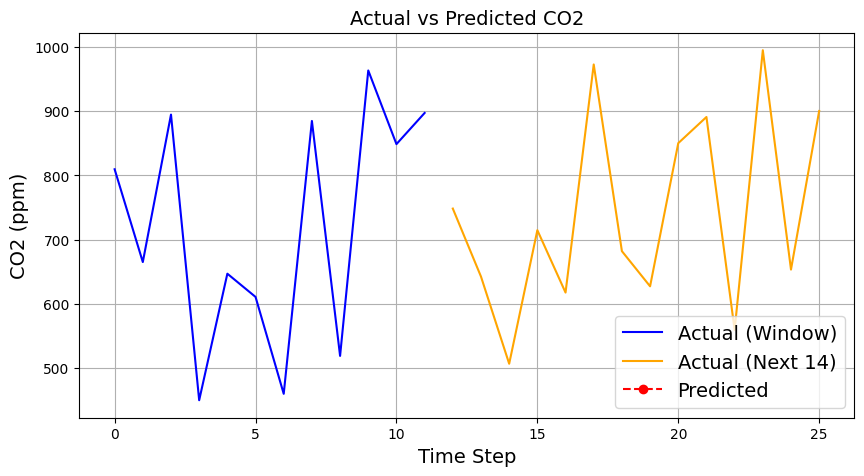

<Figure size 640x480 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Parameters ---
window_size = X.shape[1]                      # e.g. 56
num_time_step_to_predict = Y_pred.shape[1]    # e.g. 14

# --- Prepare data ---
# Extract actual data (window + next steps)
actual_values = mulvar_valid[:window_size + num_time_step_to_predict, 0].cpu().numpy() * 1e6

# Extract predicted values (just the predicted part)
y_pred = Y_pred.cpu().numpy().flatten() * 1e6

# --- Plot ---
plt.figure(figsize=(10, 5))

# Plot full actual data (first 56 + next 14)
plt.plot(
    range(window_size),
    actual_values[:window_size],
    label='Actual (Window)',
    color='blue'
)

# Highlight the next 14 timesteps (actual future)
plt.plot(
    range(window_size, window_size + num_time_step_to_predict),
    actual_values[window_size:],
    label='Actual (Next 14)',
    color='orange'
)

# Overlay predictions
plt.plot(
    range(window_size, window_size + num_time_step_to_predict),
    y_pred,
    label='Predicted',
    color='red',
    linestyle='--',
    marker='o'
)

plt.xlabel('Time Step')
plt.ylabel('CO2 (ppm)')
plt.title('Actual vs Predicted CO2')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('co2_predicted_plot.png')



Implementation: The "Responsible AI" Safety Layer


In a real-world scenario, a raw LSTM prediction shouldn't be the final word. This code adds a Rule-Based Safety Layer to catch sensor errors or dangerous CO2 spikes.



In [79]:
import numpy as np

def responsible_prediction(model, input_data, threshold=1000):
    """
    A wrapper for the LSTM model that adds Safety and Reliability checks.
    """
    # 1. Get the Raw Model Prediction
    raw_prediction = model.predict(input_data)

    # 2. Sensor Drift/Anomaly Check
    # If CO2 jumps from 400 to 2000 in 1 second, it's likely a sensor error, not physics.
    last_val = input_data[0][-1]
    if abs(raw_prediction - last_val) > 500:
        return "Warning: Rapid Change Detected. Verify Sensor Calibration."

    # 3. Safety Threshold (Responsible AI)
    # CO2 above 1000ppm affects cognitive function.
    if raw_prediction > threshold:
        return f"ALERT: High CO2 Predicted ({raw_prediction:.1f} ppm). Action: Increase Ventilation."

    return f"Status: Healthy ({raw_prediction:.1f} ppm)"